## London House Price Predictive Model
### Imports

In [1]:
import pandas as pd
from datetime import datetime as dt, timezone as tz
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('data/kaggle_london_house_price_data.csv')

In [3]:
df.dtypes

fullAddress                                   object
postcode                                      object
country                                       object
outcode                                       object
latitude                                     float64
longitude                                    float64
bathrooms                                    float64
bedrooms                                     float64
floorAreaSqM                                 float64
livingRooms                                  float64
tenure                                        object
propertyType                                  object
currentEnergyRating                           object
rentEstimate_lowerPrice                      float64
rentEstimate_currentPrice                    float64
rentEstimate_upperPrice                      float64
saleEstimate_lowerPrice                      float64
saleEstimate_currentPrice                    float64
saleEstimate_upperPrice                      f

### Data Cleaning

In [4]:
df['sale_date'] = pd.to_datetime(df['saleEstimate_ingestedAt'])

In [5]:
key_df = df.drop(columns=['history_numericChange', 'history_percentageChange', 'history_date', 'history_price','saleEstimate_valueChange.saleDate','saleEstimate_valueChange.percentageChange','saleEstimate_ingestedAt','saleEstimate_valueChange.numericChange'])

In [6]:
house_df = key_df[key_df['sale_date'] > dt(2015, 1,1).replace(tzinfo=tz.utc)] #Only considering houses with estimated values in the last 10 years

### EDA

In [7]:
house_df.isna().sum()

fullAddress                         0
postcode                            0
country                             0
outcode                             0
latitude                            0
longitude                           0
bathrooms                       77755
bedrooms                        40404
floorAreaSqM                    25066
livingRooms                     60341
tenure                          11494
propertyType                     1126
currentEnergyRating             84288
rentEstimate_lowerPrice          1101
rentEstimate_currentPrice        1101
rentEstimate_upperPrice          1101
saleEstimate_lowerPrice             0
saleEstimate_currentPrice           0
saleEstimate_upperPrice             0
saleEstimate_confidenceLevel        0
sale_date                           0
dtype: int64

In [8]:
temp_df = house_df.dropna(subset=['bathrooms', 'livingRooms','bedrooms','floorAreaSqM'])
temp_df.isna().sum() # Cannot impute the number of rooms and area of a building

fullAddress                         0
postcode                            0
country                             0
outcode                             0
latitude                            0
longitude                           0
bathrooms                           0
bedrooms                            0
floorAreaSqM                        0
livingRooms                         0
tenure                           1702
propertyType                        0
currentEnergyRating             51266
rentEstimate_lowerPrice            16
rentEstimate_currentPrice          16
rentEstimate_upperPrice            16
saleEstimate_lowerPrice             0
saleEstimate_currentPrice           0
saleEstimate_upperPrice             0
saleEstimate_confidenceLevel        0
sale_date                           0
dtype: int64

In [9]:
flat_df = temp_df[temp_df['propertyType'].str.lower().str.contains('flat')]
flat_df['tenure'].value_counts() # 98% of flats are leasehold. Would be therefore valid to impute that any flats w/o tenure are in fact leasehold

tenure
Leasehold    178804
Feudal         2796
Freehold       2039
Shared          451
Name: count, dtype: int64

In [10]:
flat_df['currentEnergyRating'].value_counts() #Normally distributed around C/D could impute with preference for B,C,D,E for flats

currentEnergyRating
C    69632
D    49279
B    22602
E     9409
F      586
A      105
G      101
Name: count, dtype: int64

In [11]:
non_flat_df = temp_df[~temp_df['propertyType'].str.lower().str.contains('flat')]

In [12]:
non_flat_df['tenure'].value_counts() #Houses tend to be freehold with 97% of houses Freehold, impute freehold for non flat properties

tenure
Freehold     128580
Leasehold      4128
Feudal           56
Shared           22
Name: count, dtype: int64

In [13]:
non_flat_df['currentEnergyRating'].value_counts() #Sharper normal distribution centered around D, could impute with preference for C,D,E

currentEnergyRating
D    64439
C    32420
E    15526
B     1714
F     1061
G      329
A      109
Name: count, dtype: int64

In [49]:
non_flat_df['bathrooms'].value_counts()

bathrooms
1.0    67646
2.0    46252
3.0    14138
4.0     3493
5.0      989
6.0      342
7.0       88
8.0       17
9.0        4
Name: count, dtype: int64

This exploration of the data has clear reasoning for imputing some fields and removing rows with missing key fields.
- Bathrooms : Cannot be reliably imputed and is necessary for the future model
- Living Rooms: Cannot be reliably imputed and is necessary for the future model
- Floor Area : Cannot be reliably imputed and is necessary for the future model
- Tenure: Can be reliably imputed and is necessary for the future model
- Energy rating: Can be reliably imputed and is necessary for the future model

### Pre-Processing

#### Imputation

In [14]:
sales_df = house_df.dropna(subset=['bathrooms', 'livingRooms', 'bedrooms', 'floorAreaSqM']) 
sales_df.drop(columns=['rentEstimate_lowerPrice', 'rentEstimate_currentPrice', 'rentEstimate_upperPrice', 'sale_date','saleEstimate_confidenceLevel'],inplace=True)
sales_df['tenure'] = sales_df['propertyType'].apply(lambda x: 'Leasehold' if 'flat' in x.lower() else 'Freehold')

C:\Users\Alex.Barnes\AppData\Local\Temp\ipykernel_32328\2432086349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.drop(columns=['rentEstimate_lowerPrice', 'rentEstimate_currentPrice', 'rentEstimate_upperPrice', 'sale_date','saleEstimate_confidenceLevel'],inplace=True)
C:\Users\Alex.Barnes\AppData\Local\Temp\ipykernel_32328\2432086349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['tenure'] = sales_df['propertyType'].apply(lambda x: 'Leasehold' if 'flat' in x.lower() else 'Freehold')


In [15]:
sales_df.columns

Index(['fullAddress', 'postcode', 'country', 'outcode', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms',
       'tenure', 'propertyType', 'currentEnergyRating',
       'saleEstimate_lowerPrice', 'saleEstimate_currentPrice',
       'saleEstimate_upperPrice'],
      dtype='object')

In [16]:
flats = sales_df[sales_df['propertyType'].str.lower().str.contains('flat')]
houses = sales_df[~sales_df['propertyType'].str.lower().str.contains('flat')]

In [17]:
for group in [flats, houses]:
    mean_rating = group['currentEnergyRating'].dropna().astype(str).mode()[0]
    std_dev = 1
    missing_idx = group['currentEnergyRating'].isna()
    group.loc[missing_idx, 'currentEnergyRating'] = np.random.choice(
        [mean_rating], size=missing_idx.sum())

In [18]:
df = pd.concat([flats, houses])

In [23]:
models = {
        # "Ridge": Ridge(),
        # "SVR": SVR(),
        "RandomForest": RandomForestRegressor(),
        "GradientBoosting": GradientBoostingRegressor()
    }

param_grids = {
        "Ridge": {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    "SVR": {
        'model__C': [1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    "RandomForest": {
        'model__n_estimators': [25, 50, 100],
        'model__max_depth': [5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
    },
    "GradientBoosting": {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.05, 0.1, 0.2]
    }
}

In [19]:
def get_standard_processor():
    numerical_features = ['bathrooms', 'bedrooms', 'floorAreaSqM', 'livingRooms']
    categorical_features = ['tenure', 'propertyType', 'currentEnergyRating']

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])
    return preprocessor

In [20]:
def get_modified_processor():
    numerical_features = [ 'floorAreaSqM']
    categorical_features = ['tenure', 'propertyType', 'currentEnergyRating', 'bathrooms',
                            'bedrooms', 'livingRooms']

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])
    return preprocessor

In [23]:
df.to_pickle("data/house_df.pkl")

In [3]:
df = pd.read_pickle("data/house_df.pkl")

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['tenure', 'propertyType', 'currentEnergyRating', 'bathrooms',
        'bedrooms', 'livingRooms', 'floorAreaSqM']], df['saleEstimate_currentPrice'], test_size=0.2, random_state=42)

In [25]:
def train_model(name,model,param_grids,preprocessor,best_models):
    print(f"Training {name}...")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    grid_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grids[name],
        n_iter=10,
        scoring="neg_mean_absolute_error",
        cv=3,
        n_jobs=10
    )
    grid_search.fit(X_train.iloc[:10000], y_train.iloc[:10000])
    best_models[name] = grid_search.best_estimator_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    return best_models

In [26]:
best_models = {}
for name,model in models.items():
    best_models = train_model(name,model,param_grids,get_standard_processor(),best_models)

Training RandomForest...
Best parameters for RandomForest: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__max_depth': 10}
Training GradientBoosting...


c:\Users\Alex.Barnes\Personal\london-house-price-predictor\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for GradientBoosting: {'model__n_estimators': 100, 'model__learning_rate': 0.1}


In [27]:
best_models = {}
for name, model in models.items():
    best_models = train_model(name, model,param_grids,get_modified_processor(),best_models)

Training RandomForest...
Best parameters for RandomForest: {'model__n_estimators': 25, 'model__min_samples_split': 10, 'model__max_depth': 10}
Training GradientBoosting...


c:\Users\Alex.Barnes\Personal\london-house-price-predictor\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for GradientBoosting: {'model__n_estimators': 300, 'model__learning_rate': 0.05}


In [30]:
CACHE_DIR = "model_cache"
os.makedirs(CACHE_DIR, exist_ok=True)
def train_model_presets(name, model, preprocessor):
    cache_path = os.path.join(CACHE_DIR, f"{name}.pkl")
    if os.path.exists(cache_path):
        print(f"Loading cached model for {name}...")
        with open(cache_path, "rb") as f:
            pipeline = pickle.load(f)
    else:
        print(f"Training {name}...")
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        pipeline.fit(X_train, y_train)
        
        # Save the trained model
        with open(cache_path, "wb") as f:
            pickle.dump(pipeline, f)
        
        print(f"Training complete for {name}. Model cached.")
    return {name: pipeline}

In [34]:
models = [
    ("GradientBoosting", GradientBoostingRegressor(n_estimators=300, learning_rate=0.05)),
    ("RandomForest", RandomForestRegressor(n_estimators=25, min_samples_split=10, max_depth=10, n_jobs=-1)),
    # ("Ridge", Ridge(alpha=10)),
]

best_models = {}
for name, model in models:
    best_models = dict(train_model_presets(name, model, get_modified_processor()), **best_models)

Training GradientBoosting...
Training complete for GradientBoosting. Model cached.
Training RandomForest...
Training complete for RandomForest. Model cached.


In [35]:
def evaluate_model(model_path, X_test, y_test):
    with open(f'model_cache/{model_path}', 'rb') as f:
        model = pickle.load(f)
    if 'upper' in model_path:
        test_set = y_test['saleEstimate_upperPrice']
    elif 'lower' in model_path:
        test_set = y_test['saleEstimate_lowerPrice']
    else:
        test_set = y_test['saleEstimate_currentPrice']
    
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(test_set, y_pred)
    rmse = np.sqrt(mean_squared_error(test_set, y_pred))
    r2 = r2_score(test_set, y_pred)

    print(f"🔹 {model_path} Performance:")
    print(f"   MAE: {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R² Score: {r2:.2f}\n")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=test_set,
                    y=y_pred, alpha=0.5)
    plt.plot([test_set.min().min(), test_set.max().max()], [test_set.min().min(
    ), test_set.max().max()], color='red', linestyle='--')
    plt.xlabel("True Sale Estimate Price")
    plt.ylabel("Predicted Sale Estimate Price")
    plt.title(f"{model_path} - True vs. Predicted Prices")
    plt.show()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['tenure', 'propertyType', 'currentEnergyRating', 'bathrooms',
        'bedrooms', 'livingRooms', 'floorAreaSqM']], df['saleEstimate_upperPrice'], test_size=0.2, random_state=42)

In [40]:
best_models = {}
for name, model in models:
    best_models = dict(train_model_presets('upper'+name, model, get_modified_processor()), **best_models)

Training upperGradientBoosting...
Training complete for upperGradientBoosting. Model cached.
Training upperRandomForest...
Training complete for upperRandomForest. Model cached.


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['tenure', 'propertyType', 'currentEnergyRating', 'bathrooms',
        'bedrooms', 'livingRooms', 'floorAreaSqM']], df['saleEstimate_lowerPrice'], test_size=0.2, random_state=42)

In [43]:
best_models = {}
for name, model in models:
    best_models = dict(train_model_presets('lower'+name, model, get_modified_processor()), **best_models)

Training lowerGradientBoosting...
Training complete for lowerGradientBoosting. Model cached.
Training lowerRandomForest...
Training complete for lowerRandomForest. Model cached.


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['tenure', 'propertyType', 'currentEnergyRating', 'bathrooms',
        'bedrooms', 'livingRooms', 'floorAreaSqM']], df[['saleEstimate_currentPrice', 'saleEstimate_lowerPrice','saleEstimate_upperPrice']], test_size=0.2, random_state=42)

🔹 GradientBoosting.pkl Performance:
   MAE: 251443.14
   RMSE: 442098.55
   R² Score: 0.71



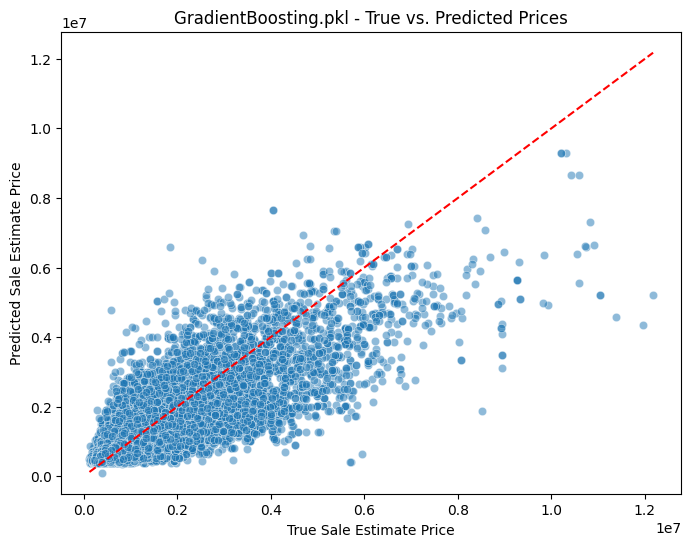

🔹 lowerGradientBoosting.pkl Performance:
   MAE: 230567.77
   RMSE: 400842.01
   R² Score: 0.71



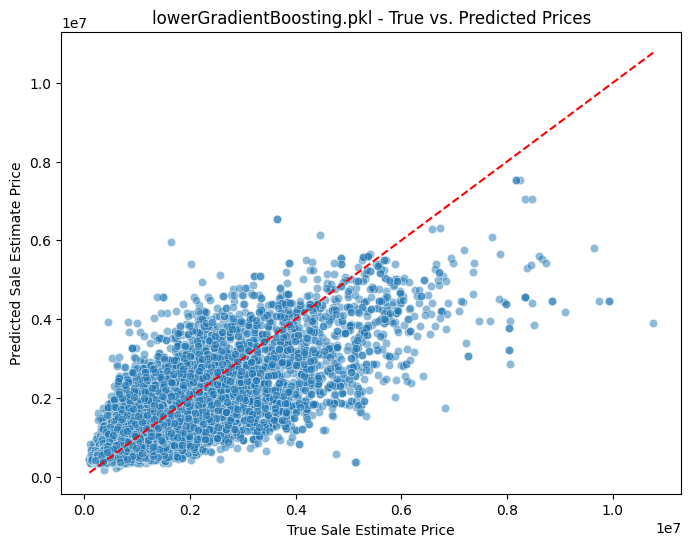

🔹 lowerRandomForest.pkl Performance:
   MAE: 220304.44
   RMSE: 376638.34
   R² Score: 0.74



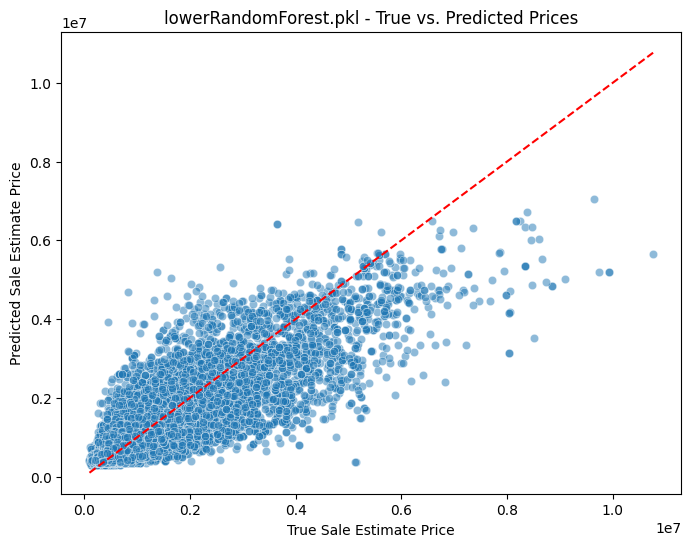

🔹 RandomForest.pkl Performance:
   MAE: 240477.44
   RMSE: 415975.54
   R² Score: 0.74



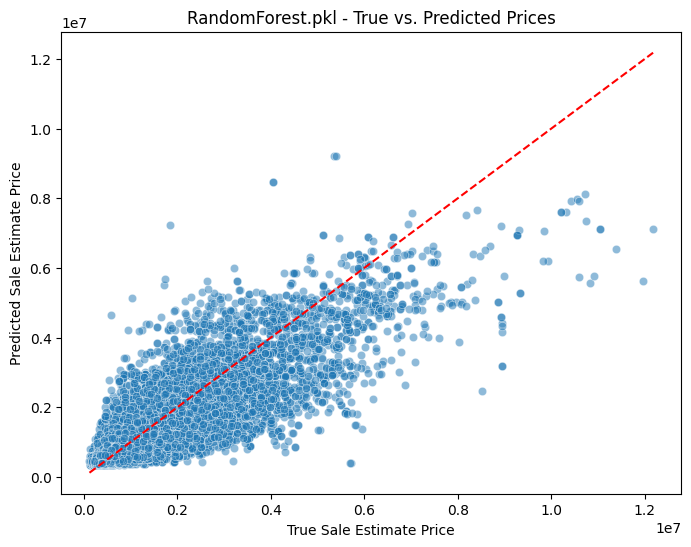

🔹 upperGradientBoosting.pkl Performance:
   MAE: 274503.13
   RMSE: 490106.26
   R² Score: 0.70



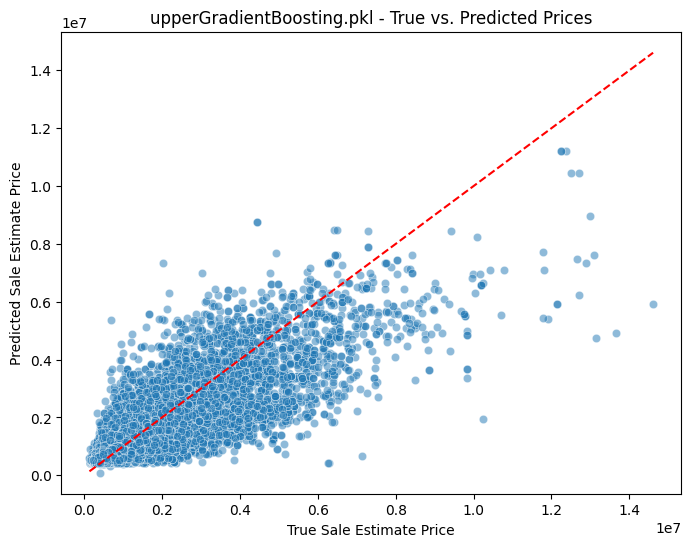

🔹 upperRandomForest.pkl Performance:
   MAE: 261814.01
   RMSE: 459839.67
   R² Score: 0.74



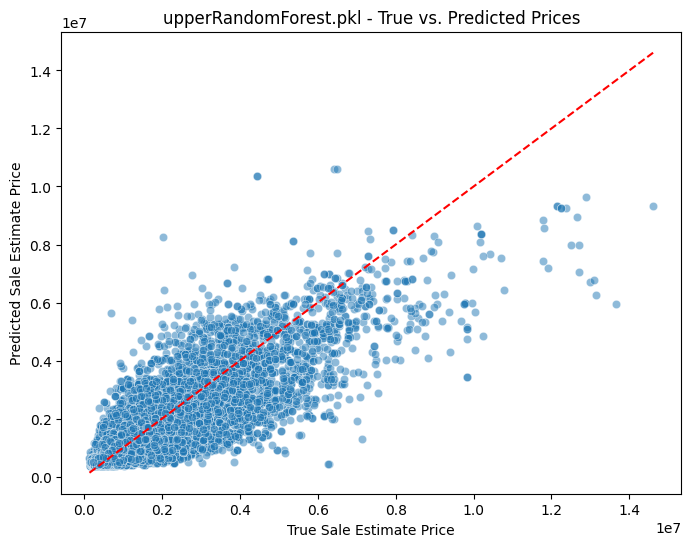

In [45]:
for path in os.listdir('model_cache'):
    evaluate_model(path, X_test, y_test)

### Key findings
- From this analysis the best performing model is the random forest. 
- We found that with an R2 of 0.74 the model could predict with an mean absolute error of 220,000 a houses' intrinsic value. 
- This means that for any given house the prediction will deviate from a perfect prediction by £220,000 pounds. However, this may be an indication of a houses value being over/underpriced in reality as opposed to the model being completely wrong

### Further analysis
- Combination of all three models (upper vs current vs lower) to produce a price range, this could be evaluated by measuring how many values lie between the range (Goal: >80% accuracy)

In [84]:
def evaluate_model(X_test, y_test):
    predictions = []
    for model_path in os.listdir('model_cache'):
        print(model_path)
        if 'random' in model_path.lower():
            print('Predicting with: %s',model_path)
            with open(f'model_cache/{model_path}', 'rb') as f:
                model = pickle.load(f)
            y_pred = model.predict(X_test)
            predictions.append(y_pred)
    for col in y_test.columns:
        predictions.append(y_test[col].tolist())
    return predictions


In [85]:
predict_df = evaluate_model(X_test,y_test)

GradientBoosting.pkl
lowerGradientBoosting.pkl
lowerRandomForest.pkl
Predicting with: %s lowerRandomForest.pkl
RandomForest.pkl
Predicting with: %s RandomForest.pkl
upperGradientBoosting.pkl
upperRandomForest.pkl
Predicting with: %s upperRandomForest.pkl


In [97]:
pred_df = pd.DataFrame(predict_df).T
pred_df = pred_df.rename(columns={0:'lower_estimate',1:'current_estimate',
                        2:'upper_estimate', 3:'current_price',4:'lower_price',
                        5:'upper_price'})
pred_df

,lower_estimate,current_estimate,upper_estimate,current_price,lower_price,upper_price
0,3.492006e+05,3.743813e+05,3.985680e+05,427000.0,406000.0,449000.0
1,1.400196e+06,1.397446e+06,1.534858e+06,591000.0,561000.0,621000.0
2,7.339929e+05,7.913107e+05,8.250081e+05,1267000.0,1204000.0,1331000.0
3,4.936052e+05,5.271942e+05,5.707851e+05,462000.0,439000.0,485000.0
4,4.158498e+05,4.425983e+05,4.607449e+05,396000.0,377000.0,416000.0
...,...,...,...,...,...,...
63711,5.751128e+05,6.183418e+05,6.531028e+05,343000.0,326000.0,360000.0
63712,5.632843e+05,5.993880e+05,6.338070e+05,524000.0,497000.0,550000.0
63713,5.886648e+05,6.348217e+05,6.788639e+05,455000.0,432000.0,478000.0
63714,3.832887e+05,4.055917e+05,4.287825e+05,383000.0,364000.0,402000.0


In [99]:
pred_df['within_bound_current'] = pred_df[['upper_estimate', 'lower_estimate', 'current_price']].apply(lambda x: x.iloc[0] >= x.iloc[2] >= x.iloc[1], axis=1)
pred_df['within_bound_lower'] = pred_df[['upper_estimate', 'lower_estimate',
                                           'lower_price']].apply(lambda x: x.iloc[0] >= x.iloc[2] >= x.iloc[1], axis=1)
pred_df['within_bound_upper'] = pred_df[['upper_estimate', 'lower_estimate',
                                           'upper_price']].apply(lambda x: x.iloc[0] >= x.iloc[2] >= x.iloc[1], axis=1)

In [100]:
print(pred_df['within_bound_current'].value_counts())
print(pred_df['within_bound_lower'].value_counts())
pred_df['within_bound_upper'].value_counts()

within_bound_current
False    53678
True     10038
Name: count, dtype: int64
within_bound_lower
False    54248
True      9468
Name: count, dtype: int64


within_bound_upper
False    53543
True     10173
Name: count, dtype: int64

In [123]:
pred_df['ext_within_bound_current'] = pred_df[['upper_estimate', 'lower_estimate',
                                           'current_price']].apply(lambda x: x.iloc[0]+150000 >= x.iloc[2] >= x.iloc[1]-150000, axis=1)
pred_df['ext_within_bound_lower'] = pred_df[['upper_estimate', 'lower_estimate',
                                         'lower_price']].apply(lambda x: x.iloc[0]+150000 >= x.iloc[2] >= x.iloc[1]-150000, axis=1)
pred_df['ext_within_bound_upper'] = pred_df[['upper_estimate', 'lower_estimate',
                                         'upper_price']].apply(lambda x: x.iloc[0]+150000 >= x.iloc[2] >= x.iloc[1]-150000, axis=1)

In [124]:
print(pred_df['ext_within_bound_current'].value_counts())
print(pred_df['ext_within_bound_lower'].value_counts())
pred_df['ext_within_bound_upper'].value_counts()

ext_within_bound_current
True     40801
False    22915
Name: count, dtype: int64
ext_within_bound_lower
True     40021
False    23695
Name: count, dtype: int64


ext_within_bound_upper
True     40675
False    23041
Name: count, dtype: int64

In [125]:
pred_df['any_within_bounds'] = pred_df[['ext_within_bound_current', 'ext_within_bound_lower', 'ext_within_bound_upper']].apply(lambda x: any(x.tolist()),axis=1)
pred_df['any_within_bounds'].value_counts()

any_within_bounds
True     46227
False    17489
Name: count, dtype: int64